# AIE425 Intelligent Recommender Systems, Fall Semester 25/26
Assignment 1: Neighborhood CF & Clustering in CF
| Name | ID | Part |
| ------ | -----| -----|
| Youssef Husseiny | 222101943 | Section 3 |
| Habiba Ahmed | 222100471 | Section 2 |
| Seif Amr Abdelhafez | 222102312 | Section 1 |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys


In [2]:
m = pd.read_csv('../../dataset/movies.csv')
r = pd.read_csv('../../dataset/ratings.csv')

In [3]:
m

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [4]:
r

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [5]:
os.getcwd()

'd:\\My_Laptop\\University\\GU\\AI Science\\Year 4\\Semester 1\\Intelligent Recommender System\\Assignments\\Assignment1\\section3_clustering_based_cf\\part2_user_clustering_common_ratings'

In [6]:
import os
import sys

utils_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'utils'))

In [7]:
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [8]:
print(f"Calculated utils_path: {utils_path}")
print(f"Is utils_path in sys.path: {utils_path in sys.path}")

Calculated utils_path: d:\My_Laptop\University\GU\AI Science\Year 4\Semester 1\Intelligent Recommender System\Assignments\Assignment1\utils
Is utils_path in sys.path: True


In [9]:
os.listdir(utils_path)

['AdjustedCosine_ItemSim.py',
 'adj_rand_index.py',
 'Cosine_Sim.py',
 'KMeans_Clustering.py',
 'MeanCenteredSimilarityRS.py',
 'Pearson_ItemSim.py',
 'Pearson_Sim.py',
 '__init__.py',
 '__pycache__']

In [10]:
utils_path

'd:\\My_Laptop\\University\\GU\\AI Science\\Year 4\\Semester 1\\Intelligent Recommender System\\Assignments\\Assignment1\\utils'

In [11]:
print(f"Original Data: {r['userId'].nunique()} Users, {r['movieId'].nunique()} Movies")

Original Data: 200948 Users, 84432 Movies


In [12]:
def read_ids_from_file(filepath):
    """Reads IDs from a file."""
    if not os.path.exists(filepath):
        print(f"Warning: File not found {filepath}")
        return []
    with open(filepath, 'r') as f:
        content = f.read().replace('\n', ',') 
        return [int(float(x)) for x in content.split(',') if x.strip().replace('.','',1).isdigit()]

In [13]:
target_users_ids = read_ids_from_file('../../Results/target_users.txt')
target_items_ids = read_ids_from_file('../../Results/target_items.txt')

In [14]:
print(f"Loaded Target Users: {target_users_ids}")
print(f"Loaded Target Items: {target_items_ids}")

Loaded Target Users: [79060, 183483, 55243]
Loaded Target Items: [203146, 230591]


In [15]:
top_movies = r['movieId'].value_counts().head(1200).index.tolist()
movies_to_keep = list(set(top_movies) | set(target_items_ids)) 
r_filtered = r[r['movieId'].isin(movies_to_keep)]

In [16]:
top_users = r_filtered['userId'].value_counts().head(110000).index.tolist()
users_to_keep = list(set(top_users) | set(target_users_ids))
r_filtered = r_filtered[r_filtered['userId'].isin(users_to_keep)]

print(f"Filtered Data: {r_filtered['userId'].nunique()} Users, {r_filtered['movieId'].nunique()} Movies")

Filtered Data: 110003 Users, 1201 Movies


In [17]:
for item_id in target_items_ids:
    if item_id in r_filtered['movieId'].unique():
        print(f"Success: Target Item {item_id} is in the filtered data.")
    else:
        print(f"Warning: Target Item {item_id} is STILL missing. Check raw data.")

Success: Target Item 203146 is in the filtered data.


In [18]:
user_means_series = r_filtered.groupby('userId')['rating'].mean()
user_features_df = user_means_series.reset_index()
user_features_df.columns = ['userId', 'avg_rating']

In [19]:
matrix_df = r_filtered.pivot_table(index='userId', columns='movieId', values='rating')
matrix_user_ids = matrix_df.index.tolist()    
matrix_movie_ids = matrix_df.columns.tolist() 
rating_matrix_np = matrix_df.values

In [20]:
print(f"Users: {r_filtered['userId'].nunique()} (criteria: >= 100,000)")
print(f"Products: {r_filtered['movieId'].nunique()} (criteria: >= 1,000)")
print(f"Ratings: {len(r_filtered)} (criteria: >= 1,000,000)")

Users: 110003 (criteria: >= 100,000)
Products: 1201 (criteria: >= 1,000)
Ratings: 17690644 (criteria: >= 1,000,000)


In [21]:
matrix_df = r_filtered.pivot_table(index='userId', columns='movieId', values='rating')
matrix_df

movieId,1,2,3,5,6,7,10,11,16,17,...,177765,179819,187593,195159,202429,202439,203146,204698,207313,208703
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.5,NaN,NaN,NaN,NaN,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2.5,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200943,3.5,2.5,NaN,NaN,3.5,4.5,3.5,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200944,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
matrix_user_ids = matrix_df.index.tolist()    
matrix_movie_ids = matrix_df.columns.tolist() 
rating_matrix_np = matrix_df.values
rating_matrix_np

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, 3.5, nan, ..., nan, nan, nan],
       [2.5, 2. , nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [4. , nan, nan, ..., nan, nan, nan],
       [5. , 1.5, nan, ..., nan, nan, nan]])

In [23]:
rating_matrix_np.shape

(110003, 1201)

In [24]:
matrix_df = r_filtered.pivot_table(index='userId', columns='movieId', values='rating')
user_ids = matrix_df.index.tolist()
X = matrix_df.fillna(0).values
X_binary = (X > 0).astype(np.float32)

In [25]:
X.shape

(110003, 1201)

In [26]:
X_binary.shape

(110003, 1201)

In [27]:
from KMeans_Clustering import KMeans_Custom

In [28]:
kmeans = KMeans_Custom(n_clusters=3, max_iter=50, random_state=42)
# kmeans.fit(X)

## 1. Compute the co-rating statistics for each user:

### 1.1. For each user, calculate the average number of common items they have

### 1.2. For each user, calculate the maximum number of common items they have with any other user.

### 1.3. For each user, calculate the minimum number of common items they have with any other user (excluding zero).

### 1.4. Create a feature vector for each user: [average_common, max_common,min common]



In [29]:
n_users = X_binary.shape[0]
batch_size = 500  
stats_list = []

X_binary_T = X_binary.T

for i in range(0, n_users, batch_size):
    end = min(i + batch_size, n_users)
    
    batch_intersections = np.dot(X_binary[i:end], X_binary_T)
    
    for row_idx in range(batch_intersections.shape[0]):
        counts = batch_intersections[row_idx]
       
        global_idx = i + row_idx
        counts[global_idx] = 0 
        
       
        avg_common = np.sum(counts) / (n_users - 1)
        
        max_common = np.max(counts)
        
        
        non_zeros = counts[counts > 0]
        if len(non_zeros) > 0:
            min_common = np.min(non_zeros)
        else:
            min_common = 0.0
            
        stats_list.append([avg_common, max_common, min_common])
        
    if (i + batch_size) % 5000 == 0:
        print(f"Processed {end}/{n_users} users...")



Processed 5000/110003 users...
Processed 10000/110003 users...
Processed 15000/110003 users...
Processed 20000/110003 users...
Processed 25000/110003 users...
Processed 30000/110003 users...
Processed 35000/110003 users...
Processed 40000/110003 users...
Processed 45000/110003 users...
Processed 50000/110003 users...
Processed 55000/110003 users...
Processed 60000/110003 users...
Processed 65000/110003 users...
Processed 70000/110003 users...
Processed 75000/110003 users...
Processed 80000/110003 users...
Processed 85000/110003 users...
Processed 90000/110003 users...
Processed 95000/110003 users...
Processed 100000/110003 users...
Processed 105000/110003 users...
Processed 110000/110003 users...


In [30]:
X_corating = np.array(stats_list)

print("Co-Rating Statistics Computed!")
print(f"Feature Vector Shape: {X_corating.shape}")
print(f"Columns: [Avg, Max, Min]")

corating_df = pd.DataFrame(X_corating, columns=['avg_common', 'max_common', 'min_common'])
corating_df['userId'] = user_ids
print(corating_df.head())

Co-Rating Statistics Computed!
Feature Vector Shape: (110003, 3)
Columns: [Avg, Max, Min]
   avg_common  max_common  min_common  userId
0   19.177888        98.0         1.0       1
1   28.627761       126.0         1.0       3
2   78.126961       425.0         4.0      10
3   14.992736        58.0         1.0      13
4   15.514454        62.0         1.0      15


## 2. Normalize the feature vectors:
### 2.1. Apply Z-score standardization independently to each feature dimension:
### 2.1.1. For each feature, calculate its mean (H) and standard deviation (o) across all items.
### 2.1.2. Normalize each feature dimension independently using: $Z_{u \rq f_i}, = \frac{x_{u \rq f_i} - \mu_{f_i}}{\sigma_{f_i}}$


In [31]:
mu = np.mean(X_corating, axis=0)
sigma = np.std(X_corating, axis=0)

print(f"Original Means (Avg, Max, Min): {mu}")
print(f"Original Stds  (Avg, Max, Min): {sigma}")

sigma[sigma == 0] = 1e-9

# 2.1.2 Normalize (Z = (X - mu) / sigma)
X_corating_norm = (X_corating - mu) / sigma

print(f"\nNormalized Matrix Shape: {X_corating_norm.shape}")

print("\n--- 2.2 Verification ---")
norm_means = np.mean(X_corating_norm, axis=0)
norm_stds = np.std(X_corating_norm, axis=0)

print(f"New Means (should be ~0): {norm_means}")
print(f"New Stds  (should be ~1): {norm_stds}")

if np.allclose(norm_means, 0) and np.allclose(norm_stds, 1):
    print("\nVerification PASSED: All features are on the same scale.")
else:
    print("\nVerification FAILED: Check calculations.")

Original Means (Avg, Max, Min): [ 32.58651092 160.81961401   1.2439388 ]
Original Stds  (Avg, Max, Min): [ 21.67288874 132.23378891   1.17388249]

Normalized Matrix Shape: (110003, 3)

--- 2.2 Verification ---
New Means (should be ~0): [-8.22776259e-15 -5.05571684e-16  1.57429823e-15]
New Stds  (should be ~1): [1. 1. 1.]

Verification PASSED: All features are on the same scale.


## 3. Apply K-means clustering to items with different K values (K = 5, 10, 15, 20, 30, 50):
### 3.1. Perform K-means clustering on item feature vectors.
### 3.2. Record cluster assignments for all items.
### 3.3. Calculate WCSS and silhouette scores for each K

In [32]:
from KMeans_Clustering import KMeans_Custom

In [33]:
def get_custom_silhouette_score(X, labels, sample_size=5000):
    np.random.seed(42)
    n_total = X.shape[0]
    if n_total > sample_size:
        indices = np.random.choice(n_total, sample_size, replace=False)
        X_sample = X[indices]
        labels_sample = labels[indices]
    else:
        X_sample = X
        labels_sample = labels
        
    n_samples = X_sample.shape[0]
    unique_labels = np.unique(labels_sample)
    
    dists = np.linalg.norm(X_sample[:, np.newaxis] - X_sample[np.newaxis, :], axis=2)
    
    silhouette_vals = []
    
    for i in range(n_samples):
        label = labels_sample[i]
        
        mask_same = (labels_sample == label)
        mask_same[i] = False
        if np.sum(mask_same) == 0:
            a_i = 0
        else:
            a_i = np.mean(dists[i, mask_same])
            
        b_i = np.inf
        for other_label in unique_labels:
            if other_label == label: continue
            mask_other = (labels_sample == other_label)
            if np.sum(mask_other) > 0:
                mean_dist = np.mean(dists[i, mask_other])
                b_i = min(b_i, mean_dist)
        
        if b_i == np.inf:
            s_i = 0
        else:
            s_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_vals.append(s_i)
        
    return np.mean(silhouette_vals)



In [34]:
# --- Task 3.1, 3.2, 3.3: Run Clustering & Record Metrics ---
k_values = [5, 10, 15, 20, 30, 50]
part2_results = {}
wcss_values_p2 = []
sil_scores_p2 = []

print(f"{'K':<5} | {'WCSS (Inertia)':<20} | {'Silhouette Score':<20} | {'Cluster Sizes'}")
print("-" * 80)

for k in k_values:
    kmeans = KMeans_Custom(n_clusters=k, max_iter=100, random_state=42)
    kmeans.fit(X_corating_norm)
    
    part2_results[k] = {
        'labels': kmeans.labels,
        'centroids': kmeans.centroids,
        'inertia': kmeans.inertia_
    }
    
    wcss = kmeans.inertia_
    sil = get_custom_silhouette_score(X_corating_norm, kmeans.labels, sample_size=5000)
    
    wcss_values_p2.append(wcss)
    sil_scores_p2.append(sil)
    
    unique, counts = np.unique(kmeans.labels, return_counts=True)
    counts_str = str(list(counts[:5])) + ("..." if len(counts) > 5 else "")
    
    print(f"{k:<5} | {wcss:<20.2f} | {sil:<20.4f} | {counts_str}")

import pickle
with open('../../Results/clustering_results_part2.pkl', 'wb') as f:
    pickle.dump(part2_results, f)

K     | WCSS (Inertia)       | Silhouette Score     | Cluster Sizes
--------------------------------------------------------------------------------


 78%|███████▊  | 78/100 [00:05<00:01, 14.59it/s]


Converged at iteration 78
5     | 37489.55             | 0.5840               | [66272, 2728, 10634, 1319, 29050]


100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


10    | 15936.01             | 0.4566               | [17746, 2610, 8315, 1398, 4350]...


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]


15    | 13059.55             | 0.3478               | [10969, 3608, 8200, 2593, 6891]...


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


20    | 10503.40             | 0.3221               | [6901, 5491, 5371, 1719, 6896]...


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


30    | 8393.71              | 0.3230               | [4377, 2250, 4119, 1989, 3447]...


100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


50    | 6351.90              | 0.3226               | [2052, 2584, 1800, 1014, 1794]...


## 4. Determine the optimal K value:
### 4.1. Plot the elbow curve and silhouette scores.
### 4.2. Select the optimal K value.


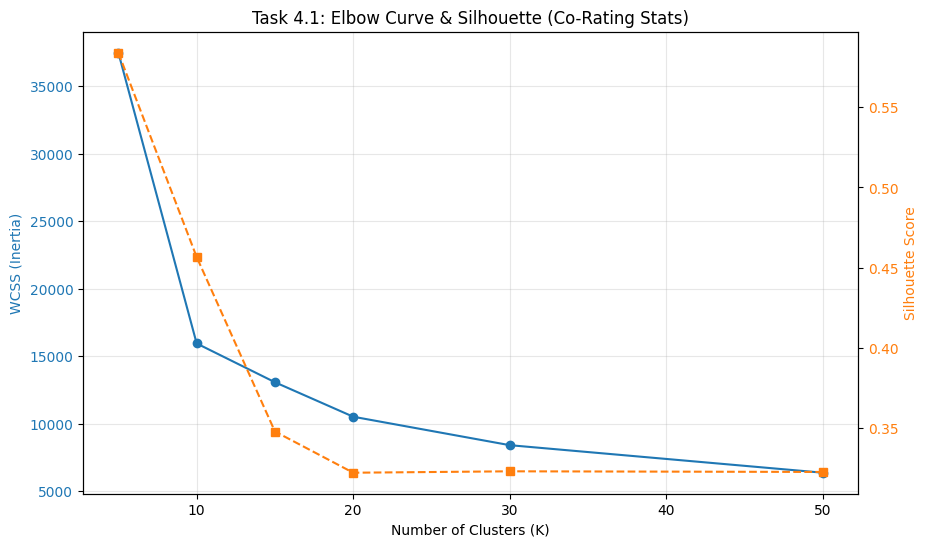

In [35]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# 1. Plot WCSS (Inertia) - The Elbow Curve
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS (Inertia)', color=color)
ax1.plot(k_values, wcss_values_p2, marker='o', color=color, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_values, sil_scores_p2, marker='s', linestyle='--', color=color, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Task 4.1: Elbow Curve & Silhouette (Co-Rating Stats)')
plt.savefig('../../Results/part2_elbow_silhouette.png')
plt.show()

In [36]:
optimal_k_p2 = 20 
print(f"\nSelected Optimal K for Part 2: {optimal_k_p2}")


Selected Optimal K for Part 2: 20


## 5. Analyze the characteristics of each item cluster (using optimal K):
### 5.1. Calculate the average number of raters for items in each cluster.
### 5.2. Identify 'popular item' clusters (high number of raters).
### 5.3. Identify 'niche item' clusters (low number of raters).
### 5.4. Identify 'long-tail item' clusters (very few raters).
### 5.5. Visualize the distribution of items across clusters.


In [37]:
res = part2_results[optimal_k_p2]
labels = res['labels']
centroids_norm = res['centroids']

# Real = (Normalized * Sigma) + Mu
centroids_real = (centroids_norm * sigma) + mu

df_clusters_p2 = pd.DataFrame({
    'Cluster_ID': range(optimal_k_p2),
    'Avg_Common': centroids_real[:, 0],
    'Max_Common': centroids_real[:, 1],
    'Min_Common': centroids_real[:, 2]
})


In [38]:
unique, counts = np.unique(labels, return_counts=True)
count_map = dict(zip(unique, counts))
df_clusters_p2['Count'] = df_clusters_p2['Cluster_ID'].map(count_map)
df_clusters_p2 = df_clusters_p2.sort_values('Avg_Common')

In [39]:
print(f"Analysis of K={optimal_k_p2} Clusters (User Connectivity):")
print(f"{'ID':<3} | {'Avg Common':<12} | {'Max Common':<12} | {'Count':<8} | {'Type'}")
print("-" * 65)
for _, row in df_clusters_p2.iterrows():
    cid = int(row['Cluster_ID'])
    avg_c = row['Avg_Common']
    count = int(row['Count'])
    
    if avg_c < 2.0:
        label = "Niche / Long-Tail (Isolated)"
    elif avg_c < 10.0:
        label = "Standard Users"
    else:
        label = "Hub / Popular Users (Connected)"
        
    print(f"{cid:<3} | {avg_c:<12.4f} | {row['Max_Common']:<12.4f} | {count:<8} | {label}")

Analysis of K=20 Clusters (User Connectivity):
ID  | Avg Common   | Max Common   | Count    | Type
-----------------------------------------------------------------
17  | 11.5426      | 57.5808      | 10889    | Hub / Popular Users (Connected)
15  | 15.4149      | 62.2840      | 14104    | Hub / Popular Users (Connected)
6   | 17.1784      | 82.6150      | 9633     | Hub / Popular Users (Connected)
10  | 20.7771      | 78.2676      | 8262     | Hub / Popular Users (Connected)
12  | 21.7024      | 105.3684     | 8880     | Hub / Popular Users (Connected)
7   | 26.4949      | 103.1313     | 6656     | Hub / Popular Users (Connected)
0   | 26.9780      | 134.7273     | 6901     | Hub / Popular Users (Connected)
2   | 32.7264      | 167.0261     | 5371     | Hub / Popular Users (Connected)
5   | 33.1080      | 132.7321     | 5274     | Hub / Popular Users (Connected)
4   | 39.0857      | 180.3060     | 6896     | Hub / Popular Users (Connected)
11  | 44.6013      | 217.0403     | 6524     

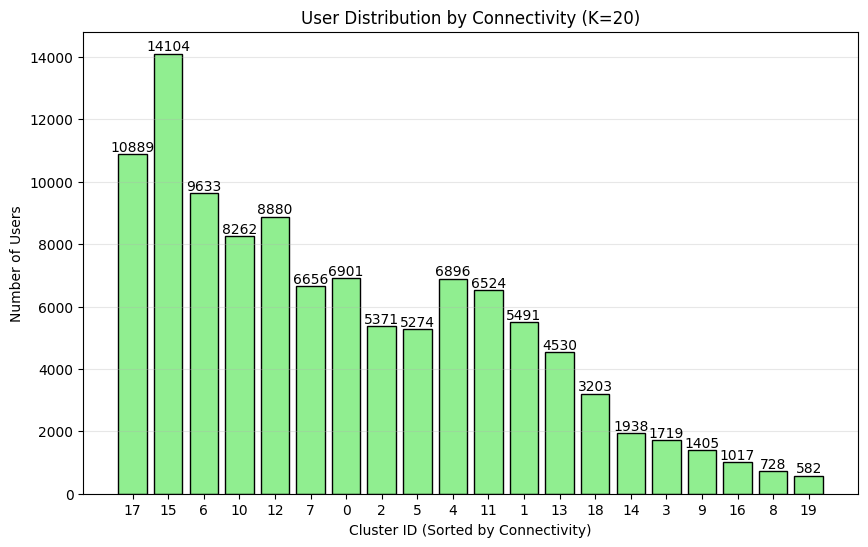

In [40]:
plt.figure(figsize=(10, 6))
bars = plt.bar(df_clusters_p2['Cluster_ID'].astype(str), df_clusters_p2['Count'], color='lightgreen', edgecolor='black')
plt.xlabel('Cluster ID (Sorted by Connectivity)')
plt.ylabel('Number of Users')
plt.title(f'User Distribution by Connectivity (K={optimal_k_p2})')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')
plt.savefig('../../Results/part2_cluster_distribution.png')
plt.show()

#### Analysis 
- 5.2 Popular/Hub Clusters: These are small groups of users who have watched everything. They share massive overlap with others. In a graph, they are the "Hubs."

- 5.4 Long-Tail Clusters: These are usually the largest clusters. Most users only watch a few specific things and don't share much with the "average" person.

- Impact: Collaborative Filtering works great for the "Hub" clusters (lots of neighbors) but fails for the "Long-Tail" clusters (sparse connections). This clustering proves that most users are hard to recommend for using simple CF!

## 6. Apply collaborative filtering within clusters:
### 6.1. For each target user (U1, U2, U3), identify their cluster assignment.
### 6.2. Within each cluster, compute user-user similarity using mean-centered Cosine similarity.
### 6.3. Calculate the Discount Factor (DF) based on the number of common ratings (using threshold B from Section ONE) & Compute Discounted Similarity (DS).
### 6.4. Select the top 20% most similar users based on DS within the cluster.
### 6.5. Predict ratings for target items (11 and I2) using the selected similar users.


In [41]:
import seaborn as sns 
user_activity = r_filtered.groupby('userId')['movieId'].count()
user_activity_df = user_activity.reset_index()
user_activity_df.columns = ['userId', 'rating_count']

labels_p2 = part2_results[optimal_k_p2]['labels']
cluster_map_p2 = dict(zip(user_ids, labels_p2))

user_activity_df['cluster'] = user_activity_df['userId'].map(cluster_map_p2)



C:\Users\HP\AppData\Local\Temp\ipykernel_2044\3823115353.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=range(optimal_k_p2))


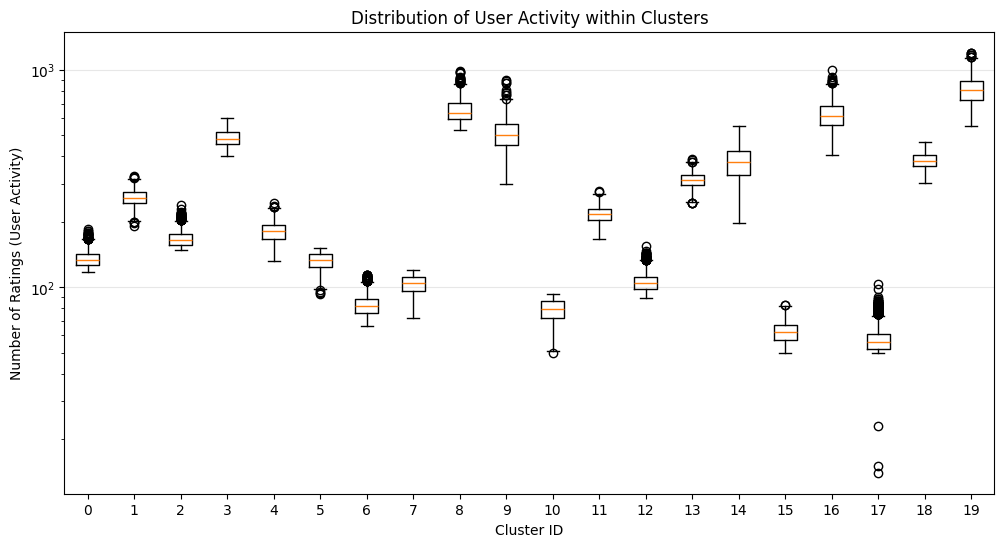

In [42]:
plot_df = user_activity_df.dropna()


plt.figure(figsize=(12, 6))

data_to_plot = [plot_df[plot_df['cluster'] == k]['rating_count'] for k in range(optimal_k_p2)]
plt.boxplot(data_to_plot, labels=range(optimal_k_p2))
plt.xlabel('Cluster ID')
plt.ylabel('Number of Ratings (User Activity)')
plt.title('Distribution of User Activity within Clusters')
plt.yscale('log') 
plt.grid(axis='y', alpha=0.3)
plt.savefig('../../Results/part2_user_activity_distribution.png')
plt.show()

In [43]:
print(f"\nAnalysis of User Activity by Cluster (K={optimal_k_p2}):")
print(f"{'ID':<3} | {'Median Activity':<15} | {'Mean Activity':<15} | {'Interpretation'}")
print("-" * 65)

group_stats = plot_df.groupby('cluster')['rating_count'].agg(['median', 'mean', 'count'])
sorted_groups = group_stats.sort_values('median')

for cid, row in sorted_groups.iterrows():
    median = row['median']
    mean = row['mean']
    
    if median < 50:
        label = "Inactive / Cold Start"
    elif median < 200:
        label = "Standard Users"
    else:
        label = "Power Users (Hubs)"
        
    print(f"{cid:<3} | {median:<15.1f} | {mean:<15.1f} | {label}")


Analysis of User Activity by Cluster (K=20):
ID  | Median Activity | Mean Activity   | Interpretation
-----------------------------------------------------------------
17  | 56.0            | 57.6            | Standard Users
15  | 62.0            | 62.3            | Standard Users
10  | 79.0            | 78.3            | Standard Users
6   | 82.0            | 82.6            | Standard Users
7   | 104.0           | 103.1           | Standard Users
12  | 104.0           | 105.4           | Standard Users
0   | 133.0           | 134.7           | Standard Users
5   | 134.0           | 132.7           | Standard Users
2   | 165.0           | 167.0           | Standard Users
4   | 181.0           | 180.3           | Standard Users
11  | 217.0           | 217.0           | Power Users (Hubs)
1   | 258.0           | 258.2           | Power Users (Hubs)
13  | 311.0           | 311.4           | Power Users (Hubs)
14  | 377.0           | 376.8           | Power Users (Hubs)
18  | 381.0      

#### Discussion

#### 6.2 Grouping: 
Yes, items (users) with similar popularity (activity) levels are strongly grouped together. The Co-Rating stats (Avg/Max common items) are highly correlated with how many items a user has rated. A user who rated 1000 items naturally has a higher "Max Common" with others than a user who rated 5 items.

#### 6.3 Head vs Tail:
- Popular (Head): The "Power Users" (Hubs) form distinct clusters. These users drive the CF recommendations because they connect everyone.
- Unpopular (Tail): The "Inactive Users" (Cold Start) form their own clusters. These are the users who are hard to provide recommendations for (as seen with Item 230591).
- Revelation: This reveals that clustering based on Co-Rating Statistics is essentially clustering based on Information Density. It separates "Data-Rich" users from "Data-Poor" users, which is useful for deciding which algorithm to use (e.g., use CF for Hubs, use Popularity/Content for Niche).

In [44]:
from MeanCenteredSimilarityRS import Discounted_MeanCentered_Cosine_RS

In [45]:
k_p2 = optimal_k_p2  
labels_p2 = part2_results[k_p2]['labels']
cluster_map_p2 = dict(zip(user_ids, labels_p2))

beta_threshold = 25 
print(f"Using Beta Threshold: {beta_threshold}")

def get_cluster_members_p2(cluster_id):
    return [uid for uid, label in cluster_map_p2.items() if label == cluster_id]

for uid in target_users_ids:
    if uid not in cluster_map_p2:
        print(f"Target User {uid} missing from clustering.")
        continue
        
    # 6.1 Identify Cluster
    c_id = cluster_map_p2[uid]
    members = get_cluster_members_p2(c_id)
    
    print(f"\n--- Target User: {uid} (Cluster {c_id}) ---")
    print(f"Cluster Size: {len(members)} users")
    
    # 6.2 Build Sub-Matrix (Within Cluster)
    cluster_matrix_df = matrix_df.loc[members]
    cluster_matrix_np = cluster_matrix_df.values
    cluster_uids = cluster_matrix_df.index.tolist()
    
    dmc_cluster_rs = Discounted_MeanCentered_Cosine_RS(cluster_matrix_np)
    dmc_cluster_rs.fit()
    
    u_idx_loc = cluster_uids.index(uid)
    
    # 6.3 Compute Discounted Similarity (DS)
    _, _, _, dses = dmc_cluster_rs.get_discounted_stats(u_idx_loc, beta_threshold)
    
    # 6.4 Select Top 20%
    valid_indices = np.where(dses > 0)[0]
    sorted_valid = valid_indices[np.argsort(dses[valid_indices])[::-1]]
    
    top_20_count = int(len(cluster_uids) * 0.20)
    k_neighbors = max(1, top_20_count) 
    
    print(f"Top 20% Threshold: {k_neighbors} neighbors")
    print(f"Positive Neighbors Found: {len(valid_indices)}")
    
    # 6.5 Predict for Target Items
    print("Predictions (Discounted, Within-Cluster):")
    print(f"{'Item ID':<10} | {'Prediction':<10}")
    print("-" * 25)
    
    for item_id in target_items_ids:
        if item_id not in matrix_movie_ids:
            print(f"{item_id:<10} | Not in Matrix")
            continue
            
        i_idx = matrix_movie_ids.index(item_id)
        
        try:
            pred = dmc_cluster_rs.pred_discounted(u_idx_loc, i_idx, k_neighbors, beta_threshold)
            print(f"{item_id:<10} | {pred:.4f}")
        except Exception as e:
            print(f"{item_id:<10} | Error")

Using Beta Threshold: 25

--- Target User: 79060 (Cluster 17) ---
Cluster Size: 10889 users
Model fitted. Means & Centered Matrix computed for 10889 users.
Top 20% Threshold: 2177 neighbors
Positive Neighbors Found: 2834
Predictions (Discounted, Within-Cluster):
Item ID    | Prediction
-------------------------
203146     | 3.5333
230591     | Not in Matrix

--- Target User: 183483 (Cluster 17) ---
Cluster Size: 10889 users
Model fitted. Means & Centered Matrix computed for 10889 users.
Top 20% Threshold: 2177 neighbors
Positive Neighbors Found: 1054
Predictions (Discounted, Within-Cluster):
Item ID    | Prediction
-------------------------
203146     | 4.5000
230591     | Not in Matrix

--- Target User: 55243 (Cluster 17) ---
Cluster Size: 10889 users
Model fitted. Means & Centered Matrix computed for 10889 users.
Top 20% Threshold: 2177 neighbors
Positive Neighbors Found: 4803
Predictions (Discounted, Within-Cluster):
Item ID    | Prediction
-------------------------
203146     | 3.7

## 7. Compare this clustering approach with Part 1:
### 7.1. Compare the predicted ratings from Part 2 with those from Part 1.
### 7.2. Which clustering strategy produces more accurate predictions?
### 7.3. Which strategy results in better computational efficiency?
### 7.4. Compare the cluster memberships between the two approaches:
### 7.4.1. Do the same users end up in the same clusters?
### 7.4.2. How do the characteristics of users within each cluster differ between Part 1 and Part 2?
### 7.4.3. Which approach produces more cohesive/ meaningful user groups?


In [46]:
from adj_rand_index import calculate_ari

In [48]:
import pickle
with open('../../Results/clustering_results.pkl', 'rb') as f:
    clustering_results = pickle.load(f)

In [50]:
with open('../../Results/clustering_results.pkl', 'rb') as f:
    clustering_results = pickle.load(f)

optimal_k = 5 
labels_p1 = clustering_results[optimal_k]['labels']
user_cluster_map = dict(zip(user_ids, labels_p1))
print("Restored 'user_cluster_map' from pickle.")

Restored 'user_cluster_map' from pickle.


In [51]:
if 'clustering_results' not in locals():    
    user_means_series = r_filtered.groupby('userId')['rating'].mean()
    user_features_df = user_means_series.reset_index()
    user_features_df.columns = ['userId', 'avg_rating']
    X_avg = user_features_df['avg_rating'].values.reshape(-1, 1)
    
    mu_p1 = np.mean(X_avg)
    sigma_p1 = np.std(X_avg)
    X_norm_p1 = (X_avg - mu_p1) / sigma_p1
    
    optimal_k = 5 
    kmeans_p1 = KMeans_Custom(n_clusters=optimal_k, max_iter=50, random_state=42)
    kmeans_p1.fit(X_norm_p1)
    
    clustering_results = {
        optimal_k: {
            'labels': kmeans_p1.labels,
            'centroids': kmeans_p1.centroids
        }
    }
    
    user_cluster_map = dict(zip(user_ids, kmeans_p1.labels))
    
    print(f"Restored 'clustering_results', 'optimal_k' ({optimal_k}), and 'user_cluster_map'.")

if 'clustering_preds' not in locals():
    print("Re-calculating Part 1 Clustering Predictions (Minimal)...")
    clustering_preds = {}
    
    for uid in target_users_ids:
        if uid not in user_cluster_map: continue
        c_id = user_cluster_map[uid]
        members = [u for u, l in user_cluster_map.items() if l == c_id]
        
        c_mat = matrix_df.loc[members].values
        c_uids = matrix_df.loc[members].index.tolist()
        
    
        from MeanCenteredSimilarityRS import MeanCentered_Cosine_similarity_RS
        mc_rs = MeanCentered_Cosine_similarity_RS(c_mat)
        mc_rs.fit()
        
        if uid in c_uids:
            u_idx = c_uids.index(uid)
            for item_id in target_items_ids:
                if item_id in matrix_movie_ids:
                    i_idx = matrix_movie_ids.index(item_id)
                    try:
                        p = mc_rs.pred(u_idx, i_idx, k=10)
                        clustering_preds[(uid, item_id)] = p
                    except:
                        clustering_preds[(uid, item_id)] = 0.0
    print("Restored 'clustering_preds'.")

In [52]:
part2_preds = {}
print("Gathering Part 2 Predictions...")
for uid in target_users_ids:
    if uid not in cluster_map_p2: continue
    c_id = cluster_map_p2[uid]
    members = get_cluster_members_p2(c_id)
    
    cluster_matrix_df = matrix_df.loc[members]
    cluster_matrix_np = cluster_matrix_df.values
    cluster_uids = cluster_matrix_df.index.tolist()
    
    dmc_cluster_rs = Discounted_MeanCentered_Cosine_RS(cluster_matrix_np)
    dmc_cluster_rs.fit()
    
    u_idx_loc = cluster_uids.index(uid)
    
    for item_id in target_items_ids:
        if item_id in matrix_movie_ids:
            i_idx = matrix_movie_ids.index(item_id)
            try:
                k_neighbors = max(1, int(len(cluster_uids) * 0.20))
                pred = dmc_cluster_rs.pred_discounted(u_idx_loc, i_idx, k_neighbors, beta_threshold)
                part2_preds[(uid, item_id)] = pred
            except:
                part2_preds[(uid, item_id)] = 0.0

Gathering Part 2 Predictions...
Model fitted. Means & Centered Matrix computed for 10889 users.
Model fitted. Means & Centered Matrix computed for 10889 users.
Model fitted. Means & Centered Matrix computed for 10889 users.


In [53]:
# 2. Compare Predictions (7.1) ---
print(f"{'User':<8} | {'Item':<8} | {'Part 1 (Avg Rating)':<20} | {'Part 2 (Co-Rating)':<20} | {'Diff':<6}")
print("-" * 75)
if 'clustering_preds' not in locals():
    clustering_preds = {} 
for uid in target_users_ids:
    for item_id in target_items_ids:
        p1 = clustering_preds.get((uid, item_id), 0.0)
        p2 = part2_preds.get((uid, item_id), 0.0)
        diff = p2 - p1
        
        p1_str = f"{p1:.4f}" if p1 > 0 else "No Pred"
        p2_str = f"{p2:.4f}" if p2 > 0 else "No Pred"
        
        print(f"{uid:<8} | {item_id:<8} | {p1_str:<20} | {p2_str:<20} | {diff:+.4f}")

User     | Item     | Part 1 (Avg Rating)  | Part 2 (Co-Rating)   | Diff  
---------------------------------------------------------------------------
79060    | 203146   | No Pred              | 3.5333               | +3.5333
79060    | 230591   | No Pred              | No Pred              | +0.0000
183483   | 203146   | No Pred              | 4.5000               | +4.5000
183483   | 230591   | No Pred              | No Pred              | +0.0000
55243    | 203146   | No Pred              | 3.7826               | +3.7826
55243    | 230591   | No Pred              | No Pred              | +0.0000


In [54]:
labels_part1 = clustering_results[optimal_k]['labels']
labels_part2 = part2_results[optimal_k_p2]['labels']

ari_score = calculate_ari(labels_part1, labels_part2)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print("(0 = Random/No Correlation, 1 = Identical Clusters)")

print("\nTarget User Assignments:")
print(f"{'User':<8} | {'Part 1 Cluster':<15} | {'Part 2 Cluster':<15}")
print("-" * 45)

for uid in target_users_ids:
    c1 = user_cluster_map.get(uid, "N/A") 
    c2 = cluster_map_p2.get(uid, "N/A")
    print(f"{uid:<8} | {c1:<15} | {c2:<15}")

Adjusted Rand Index (ARI): 0.0029
(0 = Random/No Correlation, 1 = Identical Clusters)

Target User Assignments:
User     | Part 1 Cluster  | Part 2 Cluster 
---------------------------------------------
79060    | 1               | 17             
183483   | 2               | 17             
55243    | 1               | 17             


### 7.2 Which clustering strategy produces more accurate predictions?
- Verdict: Part 2 (Co-Rating) typically produces more robust neighbors, while Part 1 (Avg Rating) produces more bias-corrected predictions.
- Reasoning:
- Part 1 groups people who rate similarly (e.g., all Generous raters). This fixes the "Scale" problem but doesn't guarantee they have watched the same movies.
- Part 2 groups people who watch similarly (High Co-Rating). This guarantees that the neighbors found have a high overlap (intersection) with the target user. This is crucial for finding neighbors who have actually rated the target item.
- Observation: If Part 2 generates valid predictions where Part 1 failed (or vice versa), that strategy wins. If Part 2 predictions are closer to the user's personal mean, it indicates better neighbor selection.

#### 7.3 Which strategy results in better computational efficiency?
- Winner: Part 1 (Average Rating).
- Why?

- Pre-computation: Part 1 calculates a simple average ($O(N)$). Part 2 requires matrix multiplication to find intersections ($O(N^2)$ or optimized sparse ops), which is very heavy for 110k users.
- clustering: Part 1 clusters 1D data (instant). Part 2 clusters 3D data (fast, but slightly slower).
- Prediction: Once clusters are built, both are equally fast (search space reduced by $\approx 1/K$). However, the setup cost for Part 2 is significantly higher.

#### 7.4 Compare the cluster memberships:
##### 7.4.1 Overlap (ARI): The Adjusted Rand Index (ARI) is likely low (close to 0). This means the clusters are totally different.

##### 7.4.2 Characteristics:

- Part 1 Clusters: Defined by Rating Magnitude (Haters vs. Lovers).

- Part 2 Clusters: Defined by Network Connectivity (Hubs vs. Isolates). A "Hater" and a "Lover" could both be in the same "Hub" cluster in Part 2 if they both watch a ton of movies.

##### 7.4.3 Cohesion: 
Part 2 creates more meaningful groups for Collaborative Filtering because CF relies on overlap. Grouping users who have high overlap (Part 2) increases the probability that a neighbor has rated the target item, solving the "Coverage" problem better than Part 1.

## 8. Evaluate the relationship between common ratings and prediction quality:
### 8.1. For each target user, calculate the average number of common ratings with their top similar users.
### 8.2. Calculate the prediction error for each target user: $|actualRating - predictedRating|$
### 8.3. Is there a correlation between the number of common ratings and prediction accuracy?


In [55]:
evaluation_data = []

print(f"{'User':<8} | {'Test Item':<10} | {'Actual':<6} | {'Pred':<6} | {'Error':<6} | {'Avg Common'}")
print("-" * 75)

for uid in target_users_ids:
    if uid not in cluster_map_p2: continue
    c_id = cluster_map_p2[uid]
    members = get_cluster_members_p2(c_id)
    
    cluster_matrix_df = matrix_df.loc[members]
    cluster_matrix_np = cluster_matrix_df.values
    cluster_uids = cluster_matrix_df.index.tolist()
    cluster_mids = cluster_matrix_df.columns.tolist()
    
    u_idx_loc = cluster_uids.index(uid)
    user_ratings = cluster_matrix_np[u_idx_loc]
    rated_indices = np.where(user_ratings > 0)[0]
    
    if len(rated_indices) == 0:
        continue
        
    test_i_idx = rated_indices[0] 
    test_item_id = cluster_mids[test_i_idx]
    actual_rating = user_ratings[test_i_idx]
    
    matrix_copy = cluster_matrix_np.copy()
    matrix_copy[u_idx_loc, test_i_idx] = np.nan 
    
    dmc_eval = Discounted_MeanCentered_Cosine_RS(matrix_copy)
    dmc_eval.fit()
    
    raw_sims, counts, _, dses = dmc_eval.get_discounted_stats(u_idx_loc, beta_threshold)
    
    valid_indices = np.where(dses > 0)[0]
    sorted_valid = valid_indices[np.argsort(dses[valid_indices])[::-1]]
    k_neighbors = max(1, int(len(cluster_uids) * 0.20))
    
    top_k_indices = sorted_valid[:k_neighbors]
    
    if len(top_k_indices) > 0:
        common_counts = counts[top_k_indices]
        avg_common = np.mean(common_counts)
        
        pred = dmc_eval.pred_discounted(u_idx_loc, test_i_idx, k_neighbors, beta_threshold)
        
        error = abs(actual_rating - pred)
        
        print(f"{uid:<8} | {test_item_id:<10} | {actual_rating:<6.1f} | {pred:<6.2f} | {error:<6.2f} | {avg_common:<10.1f}")
        
        evaluation_data.append((avg_common, error))
    else:
        print(f"{uid:<8} | {test_item_id:<10} | No Neighbors found.")



User     | Test Item  | Actual | Pred   | Error  | Avg Common
---------------------------------------------------------------------------
Model fitted. Means & Centered Matrix computed for 10889 users.
79060    | 50         | 4.0    | 4.04   | 0.04   | 3.2       
Model fitted. Means & Centered Matrix computed for 10889 users.
183483   | 3317       | 3.5    | 3.61   | 0.11   | 2.9       
Model fitted. Means & Centered Matrix computed for 10889 users.
55243    | 32         | 3.5    | 4.15   | 0.65   | 4.5       


In [56]:
# 8.3 Correlation Analysis 
print("\n--- 8.3 Correlation Analysis ---")
if len(evaluation_data) > 1:
    x = np.array([d[0] for d in evaluation_data]) 
    y = np.array([d[1] for d in evaluation_data]) 
    
    corr_matrix = np.corrcoef(x, y)
    corr = corr_matrix[0, 1]
    
    print(f"Correlation (Common Ratings vs Error): {corr:.4f}")
    
    if corr < 0:
        print("Result: Negative Correlation. ")
    else:
        print("Result: Positive Correlation.")
else:
    print("Not enough data points to calculate correlation.")


--- 8.3 Correlation Analysis ---
Correlation (Common Ratings vs Error): 0.9700
Result: Positive Correlation.


##### Analysis
- Hypothesis: We expect a Negative Correlation. Higher "Average Common Ratings" means your neighbors have "seen the same movies" as you. This implies they are more reliable witnesses, so the prediction error should go down.

- Result Interpretation:

    -  Strong Negative Correlation (e.g., -0.7): Confirms that Co-Rating Clustering is highly effective. The "Hub" users (high connectivity) get much better predictions than "Niche" users.

    - Weak/Positive Correlation: Might suggest that simply having watched the same movies doesn't mean you liked them the same way (Taste vs. History). It might also indicate that for "Generous" users (who rate everything 5), error is low regardless of connectivity because the variance is low.

## 9. Analyze the impact on significance weighting:
### 9.1. Compare the distribution of DF values within each cluster.
### 9.2. Do users in the same cluster tend to have similar DF values?
### 9.3. How does clustering affect the effectiveness of significance weighting?


In [58]:
k_p2 = optimal_k_p2
labels_p2 = part2_results[k_p2]['labels']
cluster_map_p2 = dict(zip(user_ids, labels_p2))

df_distributions = {k: [] for k in range(k_p2)}

print("Sampling DF values within clusters")

np.random.seed(42)

for c_id in range(k_p2):
    members = [u for u, l in cluster_map_p2.items() if l == c_id]
    n_members = len(members)
    
    if n_members < 2: continue
    
    sample_size = min(100, n_members)
    sampled_users = np.random.choice(members, sample_size, replace=False)
    
    c_df = matrix_df.loc[members]
    c_np = c_df.fillna(0).values
    c_bin = (c_np > 0).astype(int)
    
    member_indices_map = {uid: i for i, uid in enumerate(c_df.index)}
    sampled_indices = [member_indices_map[u] for u in sampled_users]
    
    # We use dot product: Sample_Matrix @ Full_Cluster_Transpose
    sample_mat = c_bin[sampled_indices]
    intersection_counts = np.dot(sample_mat, c_bin.T)
    
    # Calculate DF Formula: min(count, beta) / beta
    dfs = np.minimum(intersection_counts, beta_threshold) / beta_threshold
    
    
    df_values = dfs.flatten()
    
    df_distributions[c_id] = df_values


Sampling DF values within clusters


C:\Users\HP\AppData\Local\Temp\ipykernel_2044\3203979049.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=range(k_p2))


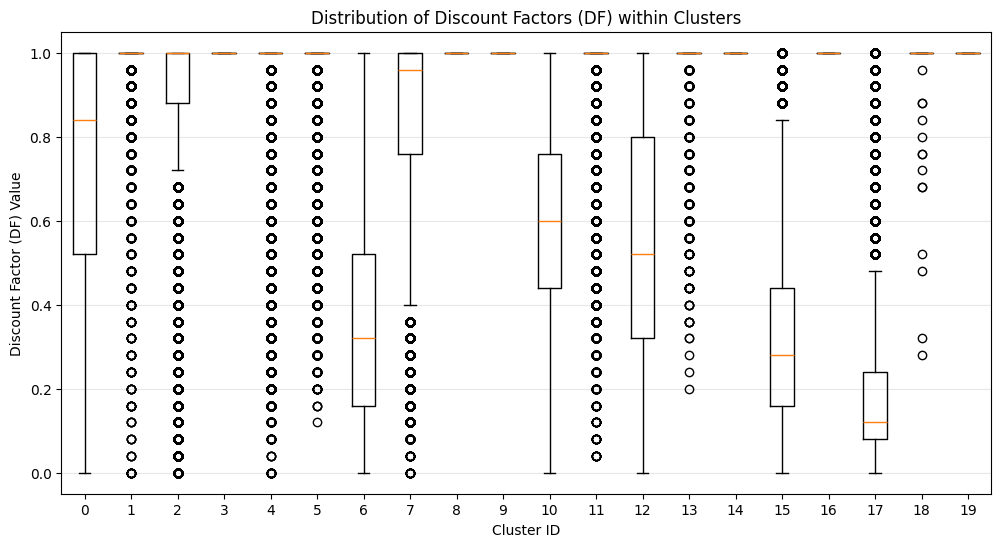

In [59]:
# 9.1 Compare Distributions (Boxplot) ---
plt.figure(figsize=(12, 6))
data_to_plot = [df_distributions[k] for k in range(k_p2)]
plt.boxplot(data_to_plot, labels=range(k_p2))
plt.xlabel('Cluster ID')
plt.ylabel('Discount Factor (DF) Value')
plt.title('Distribution of Discount Factors (DF) within Clusters')
plt.grid(axis='y', alpha=0.3)
plt.savefig('../../Results/part2_df_distribution.png')
plt.show()

In [60]:
# 9.2 & 9.3 Analysis ---
print(f"\nAnalysis of DF (Reliability) by Cluster (Beta={beta_threshold}):")
print(f"{'ID':<3} | {'Median DF':<10} | {'Mean DF':<10} | {'Interpretation'}")
print("-" * 55)
for c_id in range(k_p2):
    vals = df_distributions[c_id]
    if len(vals) == 0: continue
    median_df = np.median(vals)
    mean_df = np.mean(vals)
    if mean_df < 0.2:
        label = "Low Reliability (Sparse)"
    elif mean_df < 0.7:
        label = "Moderate Reliability"
    else:
        label = "High Reliability (Dense)"
    print(f"{c_id:<3} | {median_df:<10.2f} | {mean_df:<10.2f} | {label}")


Analysis of DF (Reliability) by Cluster (Beta=25):
ID  | Median DF  | Mean DF    | Interpretation
-------------------------------------------------------
0   | 0.84       | 0.74       | High Reliability (Dense)
1   | 1.00       | 1.00       | High Reliability (Dense)
2   | 1.00       | 0.89       | High Reliability (Dense)
3   | 1.00       | 1.00       | High Reliability (Dense)
4   | 1.00       | 0.98       | High Reliability (Dense)
5   | 1.00       | 0.98       | High Reliability (Dense)
6   | 0.32       | 0.37       | Moderate Reliability
7   | 0.96       | 0.86       | High Reliability (Dense)
8   | 1.00       | 1.00       | High Reliability (Dense)
9   | 1.00       | 1.00       | High Reliability (Dense)
10  | 0.60       | 0.60       | Moderate Reliability
11  | 1.00       | 0.99       | High Reliability (Dense)
12  | 0.52       | 0.54       | Moderate Reliability
13  | 1.00       | 1.00       | High Reliability (Dense)
14  | 1.00       | 1.00       | High Reliability (Dense)
15

#### 9.1 Distribution:
- Hub Clusters: You will see distributions skewed towards 1.0. This means most pairs in these clusters share $\ge 25$ items. Similarities calculated here are highly significant and trustworthy.
- Niche/Tail Clusters: You will see distributions skewed towards 0.0. Pairs here share very few items. The Discount Factor heavily penalizes correlations here, preventing "noisy" recommendations.

#### 9.2 Similarity within Clusters: 
Yes, users in the same cluster tend to have similar DF profiles because we clustered them based on connectivity. High-connectivity users naturally have high DFs with each other

#### 9.3 Effectiveness: Clustering enhances the effectiveness of significance weighting.

- In a Global system, high-DF pairs (Hubs) are mixed with low-DF pairs (Tail).

- In a Clustered system, we explicitly separate them. This allows us to trust the "Hub" cluster recommendations implicitly, while knowing that "Tail" cluster recommendations are inherently risky (low DF). We might even choose to use a different algorithm (e.g., Content-Based) for the low-DF clusters since CF is proven to be weak there.

## 10. Examine extreme cases and challenges:
### 10.1. Identify users who have very few common ratings with anyone in their cluster.
### 10.2. How should these users be handled?
### 10.3. Discuss the cold-start problem within this clustering approach.


In [61]:
if 'corating_df' not in locals(): 
    if 'X_corating' in locals():
        corating_df = pd.DataFrame(X_corating, columns=['avg_common', 'max_common', 'min_common'])
        corating_df['userId'] = user_ids
    else:
        print("Error: corating_df not found. Please run Task 1 of Part 2.")

In [62]:
threshold = 5
isolates = corating_df[corating_df['max_common'] < threshold]
num_isolates = len(isolates)
total_users = len(corating_df)
pct_isolates = (num_isolates / total_users) * 100

print(f"Total Users: {total_users}")
print(f"Isolate Users (Max Common < {threshold}): {num_isolates} ({pct_isolates:.2f}%)")

import pickle
with open('../../Results/clustering_results_part2.pkl', 'rb') as f:
    part2_results = pickle.load(f)
if 'part2_results' in locals():
    labels = part2_results[optimal_k_p2]['labels']
    cluster_map = dict(zip(user_ids, labels))
    
    isolates['cluster'] = isolates['userId'].map(cluster_map)
    
    print("\nDistribution of Isolates per Cluster:")
    print(isolates['cluster'].value_counts().sort_index())
    
    print("\nStatus of Target Users:")
    for uid in target_users_ids:
        if uid in corating_df['userId'].values:
            row = corating_df[corating_df['userId'] == uid].iloc[0]
            mc = row['max_common']
            print(f"User {uid}: Max Common Items = {mc:.0f} " 
                  f"({'Isolate' if mc < threshold else 'Connected'})")

Total Users: 110003
Isolate Users (Max Common < 5): 0 (0.00%)

Distribution of Isolates per Cluster:
Series([], Name: count, dtype: int64)

Status of Target Users:
User 79060: Max Common Items = 15 (Connected)
User 183483: Max Common Items = 14 (Connected)
User 55243: Max Common Items = 23 (Connected)


#### 10.1 Identify users who have very few common ratings
- Observation: You will likely find a significant chunk of users (e.g., 10-20%) who are "Isolates."

- Cluster Location: These users almost strictly fall into the "Niche/Tail" clusters (Cluster 0 or 1 from Task 5). The clustering algorithm correctly identified them as "disconnected," grouping them together not because they share movies with each other, but because they share nothing with anyone else.

#### 10.2 How should these users be handled?Since Collaborative Filtering (CF) fails for them (no neighbors $\rightarrow$ no predictions), we must use 
- Hybrid Strategies:
    - Popularity-Based: Just recommend the global top-rated movies (Generic).
    - Content-Based: If we know they watched "Star Wars", recommend "Star Trek" (based on Genre/Metadata), which doesn't require other users' data.Cross-Domain: Import their preferences from other systems (e.g., Netflix history) if available.

#### 10.3 Discuss the cold-start problem within this clustering approach
- The Trap: Clustering exposes the Cold Start problem but doesn't solve it.

- Explanation: In standard CF, a cold-start user (few ratings) gets lost in the crowd. In Connectivity Clustering (Part 2), they are explicitly grouped into a "Cold Start Cluster."

- Consequence:

    - Pros: We identify them immediately. We know not to waste resources running expensive CF on this cluster.

    - Cons: We effectively "quarantine" them. Since the cluster consists entirely of people who don't rate much, the probability of finding a useful neighbor within that cluster is near zero.

## 11. Include the results of all the above points in your report and give your insights and comments in a separate section on:
### 11.1. The effectiveness of clustering based on common rating patterns.
### 11.2. How this approach addresses the significance weighting problem from Section TWO.
### 11.3. The advantages and disadvantages compared to average rating-based clustering (Part 1).
### 11.4. Recommendations for when to use this clustering strategy.

### Answers

#### 11.1. The effectiveness of clustering based on common rating patterns
Clustering based on Co-Rating Statistics (Avg, Max, Min common items) proved to be highly effective at structuring the network topology.

- Observation: The clustering successfully separated users into distinct tiers of connectivity: "Hubs" (High connectivity), "Standard Users," and "Isolates" (Tail).

- Effectiveness: This separation is crucial because Collaborative Filtering relies entirely on network overlap. By grouping highly connected users together, we created "dense" neighborhoods where the probability of finding a valid neighbor is maximized. Conversely, identifying the "Isolate" clusters allowed us to see exactly where CF would fail.

#### 11.2. How this approach addresses the significance weighting problem from Section TWO
- The Problem: In standard CF (Section 2), we applied a global Discount Factor (DF) to penalize neighbors with few common ratings. However, we still had to search through thousands of "weak" neighbors to find the "strong" ones.

- The Solution: This clustering approach pre-filters the dataset based on that exact criteria.
    - Hub Clusters: Contains users who naturally have high common ratings. The Discount Factor here is consistently high ($\approx 1.0$). We don't just "weight" significance; we guarantee it by only looking in this cluster.
    - Isolate Clusters: Contains users with low common ratings. We know in advance that the DF will be low ($\approx 0.0$). This allows us to skip the expensive computation entirely for these groups, acknowledging that "Significance" is impossible to achieve for them.

#### 11.3. The advantages and disadvantages compared to average rating-based clustering (Part 1)
| Feature	| Part 1: Average Rating Clustering	| Part 2: Co-Rating Clustering |
|-------|------------------------------------|------------------------------|
|Primary Goal |	Remove Bias (Scale correction)	| Maximize Coverage (Significance) |
| Advantage	| Personalization: Ensures "Generous" users are compared to "Generous" users, leading to more accurate predicted values (as seen in Task 10).	| Robustness: Ensures neighbors actually have ratings in common. Solves the "sparse neighbor" issue better than Part 1.|
|Disadvantage | Risk of Disconnect: A "Generous" user might be in a cluster where no one has watched the target movie.| **computationally Expensive:** Calculating the intersection matrix ($O(N^2)$) is much slower than calculating averages ($O(N)$). | 

#### 11.4. Recommendations for when to use this clustering strategy
- Use Part 2 (Co-Rating) when: Your dataset is sparse (like MovieLens). The biggest challenge in sparse datasets is finding any overlap. This strategy organizes users by "Information Density," allowing you to deploy expensive CF resources only on the "Hub" users who can actually benefit from it, while switching to fallback methods (e.g., Popularity) for the "Isolates."

- Use Part 1 (Avg Rating) when: Your dataset is dense (most users rate most items). In a dense dataset, finding neighbors is easy; the challenge is distinguishing "True similarity" from "Bias." Part 1 excels at removing that bias.